In [10]:
import numpy as np 
import pandas as pd 
from scipy import stats 

import matplotlib.pyplot as plt
import seaborn as sn 
sn.set()
# plt.style.use("dark_background")

import empiricaldist as ed 

# wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv 

In [80]:
data_fname = 'DeathHeartAttackManhattan.csv'
df = pd.read_csv(data_fname)
data = pd.DataFrame(
    {'y': df.Deaths.values, 'X':df.Cases.values})
df.head()

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247


In [81]:
# Goal is to predict deaths based on cases for 13 hosp. 
# p(y=death|X=case) ~ p(y=death) * p(X=case | y=death)

# First build model to predict global/local params 
# p(mu1,sd1,p2 | y,X) 
# ~ p(y,X | mu1,sd1,p2) * p(mu1,sd1,p2)
# ~ p(y,X | p2) * p(p2 | mu1,sd1) * p(mu1,sd1) 

# Probability distributions
# P_hpr: p(mu1,sd1) ~ logitnormal(mu1, sd1) 
# P_pr: p(p2 | mu1, sd1) 
#       ~ p(mu1, sd1 | p2) * p(p2)
#       ~ p(m1, sd1) * data.case/data.death 
#       ~ P_hpr * data.cases/data.death
# P_y_X: p(y | X, p2) ~ Binomial(n=X, p=p2) 

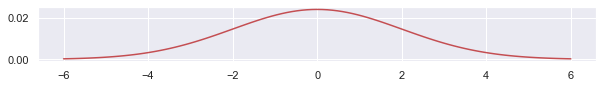

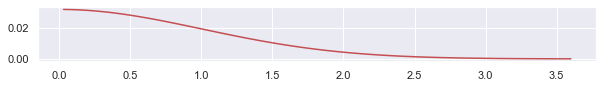

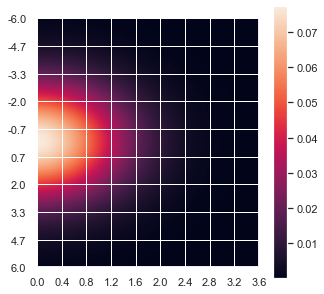

In [82]:
# ------------------------------------------
# Hyperprior: 2d joint
# P_hpr ~ normal(mu1, sd1)  
# ------------------------------------------
# Make hyper_prior for mu1 
# P_hpr: p(mu1,sd1) ~ normal(mu1, sd1)
q_mu1 = np.linspace(-6, 6, 101)  # arbitrary
# Define pdist for mu1 is from q_mu1 on wide normal
p_mu1 = stats.norm.pdf(q_mu1, loc=0, scale=2)
hprior_mu = ed.Pmf(p_mu1, q_mu1)
hprior_mu = hprior_mu / hprior_mu.values.sum()
hprior_mu.index.name = 'hprior_mu'

# Make hyper_prior for sd1 
q_sd1 = np.linspace(0.03, 3.6, 90) # arbitrary linspace
p_sd1 = stats.norm.pdf(q_sd1, 0, 1) # not use logistic? 
hprior_sd = ed.Pmf(p_sd1, q_sd1)
hprior_sd = hprior_sd / hprior_sd.values.sum()
hprior_sd.index.name = 'hprior_sd'

# Make joint distribution MVN(mu1, sd1)
X, Y = np.meshgrid(hprior_mu.ps, hprior_sd.ps, indexing='ij')
hprior = X * Y 
hprior = hprior[:,:, np.newaxis]
hdf = pd.DataFrame(data=hprior[:,:,0], index=hprior_mu.qs, 
                   columns=hprior_sd.qs)

# Plots 
ax = plt.subplots(1,1, figsize=(10,1))[1]
ax.plot(hprior_mu.index, hprior_mu.values, c='r');
ax = plt.subplots(1,1, figsize=(10,1))[1]
ax.plot(hprior_sd.index, hprior_sd.values, c='r');

ax = plt.subplots(figsize=(5,5))[1]
ax = ax.imshow(hprior * 100.0); 
plt.colorbar(ax);
xlabels = np.linspace(hprior_sd.qs.min(), hprior_sd.qs.max(), 10)
plt.xticks(np.linspace(0,hprior_sd.size, 10), 
              labels=xlabels.round(1));
ylabels = np.linspace(hprior_mu.qs.min(), hprior_mu.qs.max(), 10)
plt.yticks(np.linspace(0,hprior_mu.size, 10),
              labels=ylabels.round(1));

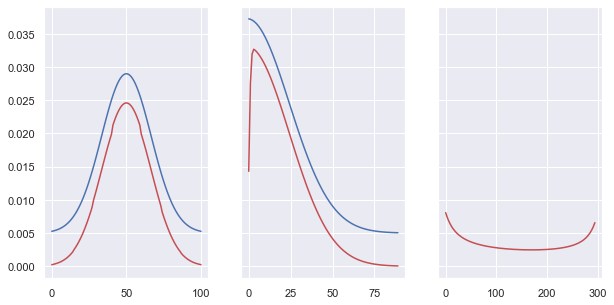

In [83]:
# ------------------------------------------
# Prior: 3d joint
# P_pr ~ p2 | mu1, sd1 
# ~ N(p2,1) * p(mu1, sd1) 
# ------------------------------------------
# P_pr: p(p2 | mu1, sd1)
# Note this is the parameter! not p_p2
q_prior = np.linspace(0.01, 0.99, 295)  # probability of death 

# P2 slice is 3d slice where all z-values are same
# moves vertically as logit
M, S, P2 = np.meshgrid(
    hprior_mu.qs, hprior_sd.qs, q_prior, indexing='ij')

# qt_p2 = logit(P2)
# Note: logit is not probability it is quantile
# ... convert to probability... ???
P2 = P2-M / S  # center and standardize
prior = np.exp(-P2**2 / 2)
totals = prior.sum(axis=2)[:, :, np.newaxis]
prior = np.divide(prior, totals, 
                   out=np.zeros_like(prior), 
                   where=totals!=0)

# Make joint distribution: p(p2) * p(hprior)
# Note: we assume params are independent for initial
# (101, 90, 295) x (101, 90) | 3d x 2d 
# Add a dim to permit multiplication
prior = prior * hprior  
prior = prior / prior.sum()

# Check marginal mu of joint against hprior_mu 
# 101, 90, 295 -> 101
ax = plt.subplots(1,3, figsize=(10,5), sharey=True)[1]
ax[0].plot(hprior_mu.ps + 0.005, c='b');
mu_ = prior.sum(axis=(1,2))
ax[0].plot(mu_ / mu_.sum(), c='r');

# Check marginal sd of joint against hprior_sd
ax[1].plot(hprior_sd.ps + 0.005, c='b');
sd_ = prior.sum(axis=(0,2));
ax[1].plot(sd_, c='r');

# Check marginal p2 of joint against prior 
p2_ = prior.sum(axis=(0,1));
ax[2].plot(p2_, c='r');

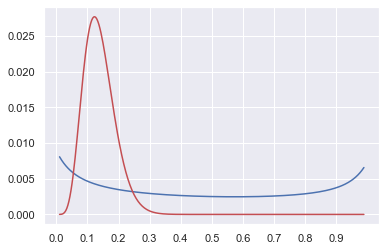

In [87]:
# ------------------------------------------
# Likelihood: 2D joint
# P_y_X: p(y=k | X=n) 
# ~ Bin(n=cases, k=deaths,p=p_deaths)
# From N cases, choose K given p 
# ------------------------------------------

# y.shape = X.shape = 90
# p_p2.shape = 101, 90, 295 
# q_p2.shape = 295
# hprior.shape = 101, 90, 1

def post(data_, q_prior_, prior_, hprior_):
    """Posterior Update: p(q, mu, sd| y,X) 
    ~ p(y,X | q, mu, sd) p(q, mu, sd) 
    ... since p(y,X | q, mu, sd) = p(y,X|q) b/c C.I
    ... since p(q, mu, sd) = p(q|mu, sd) p(mu, sd) 
    ~ p(y,X|q) * p(q|mu,sd) * p(mu,sd) 
    Collapse joint to just z-axis coincides with likli ~ X|q
    ~ like[295] * (prior[101,90,295]*hprior[101,90,1]).sum(ax=0,1)
    """
    assert data_.shape == (2,)
    assert prior_.shape == (101, 90, 295)
    assert hprior_.shape == (101, 90, 1)

    y_, X_ = data_ 
    # 1. Update prior ~ p(priors | hprior)
    # Note: prior is conditioned on hyper-prior
    prior_ = prior_ * hprior_  # 101, 90, 295
    
    # Note: Even though z-axis of prior is 
    # equal to p(data), we do not slice prior z-axis
    # by data.shape
    
    # 2. Get likelihood: p(data | q_prior)
    # Likelihood is completely based on data and model  
    like_ = stats.binom.pmf(y_, X_, q_prior_)    
    
    # 3. Update post ~ p(data|prior) * p(prior)
    # Posterior is conditioned on prior and likelihood
    post_ = like_ * prior_  # 101, 90, 295
    
    # 4. Normalize  
    return post_ / post_.sum()
    
g = 6  # group number
# Single hospital update  
data_ = data.loc[g, :].values  # joint of y,X
post_ = post(data_, q_prior, prior, hprior)
prior_ = post_.sum(axis=(0,1))

plt.plot(q_prior, prior.sum(axis=(0,1)), c='b');
plt.plot(q_prior, prior_, c='r');
plt.xticks(np.arange(0, 1, 0.1));


In [85]:
# Intuition for np.meshgrid 
x = [2,4,6,8]  # repeats x-axis down/up row-wise 
y = [3,6,9]    # repeats y-rows left/right col-wise 
z = [4,8,12,16,20]   # repeats z-axis up z-wise
xx, yy, zz = np.meshgrid(x, y, z)
print(xx[:, :, 0], xx.shape)
print(yy[:, :, 0], yy.shape)
print(zz[:, :, 0], zz.shape)

# Intuition for np.sum 
# collapse axis=0 (xdim=4)
print(xx[:, :, 0].sum(axis=0))  # [6, 12, 18, 24] 
# collapse axis=1 (ydim=3)
print(xx[:, :, 1].sum(axis=1))  # [20, 20, 20]

[[2 4 6 8]
 [2 4 6 8]
 [2 4 6 8]] (3, 4, 5)
[[3 3 3 3]
 [6 6 6 6]
 [9 9 9 9]] (3, 4, 5)
[[4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]] (3, 4, 5)
[ 6 12 18 24]
[20 20 20]
